In [1]:
%load_ext nb_black
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats

%matplotlib inline
set_matplotlib_formats("svg")
plt.style.use("seaborn-white")
import numpy as np
import seaborn as sns
from IPython.display import SVG

import jax
import numpy as np

jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp

<IPython.core.display.Javascript object>

# Lecture 12
## Coalescent Hidden markov models

In the past few weeks, we studied inference methods which assume that evolution at each gene occurs indepenedently. We studied the allele frequency spectrum, which describes the distribution of the number of variant copies of a gene (Lecture 8), as well as the Pritchard-Stephens-Donnelly model (Lecture 10), which clusters together different samples based on a model that assumes complete independence between gene frequencies at different genes. 

This week, we'll go back to thinking about recombination and genes that evolve under the presence of linkage disequilibrium. We will use hidden Markov modeling to perform inference under this set of assumptions.


We already saw an example of a hidden Markov model when we described the sequentially Markov coalescent (Lecture 6). In that lecture, we first generated a sequence of trees for two leaves, and then dropped mutations on them to generate data. 

We will extend this model in two ways:
1. Still for sample size $n=2$, we will infer this sequence of trees, and use it to estimate the size of the population backwards in time.
2. For sample size $n>2$, inferring trees becomes too complicated, so we will make a (strong) simplifying assumption regarding the nature of tree topologies, which leads to a simple yet powerful algorithm for inferring ancestry.

Bullet point #1 leads to the program PSMC ([Li & Durbin; *Nature*, 2011](https://www.nature.com/articles/nature10231)). Bullet point #2 leads to the method of Li & Stephens ([*Genetics*, 2003](https://www.genetics.org/content/165/4/2213.long)). Both of these papers are extremely influential.

## The Li-Stephens haplotype copying model
Li and Stephens (2003) were interested in computing the likelihood of a sample $H_1,\dots,H_n$ of haplotypic data

$$\mathbb{P}_\theta(H_1,\dots,H_n),$$

where $\theta$ represents various parameters of some evolutionary model (in this case, recombination.)

Their insight was that, if we had a good approximation for the *conditional* probability $\tilde{P}_\theta(H_i\mid H_{i-1},\dots,H_1)$, then we could use it to perform likelihood-based inference.

Using the chain rule of probability, we have 
\begin{align}
\mathbb{P}_\theta(H_1,\dots,H_n) &= \pi_\theta(H_1) \prod_{i=2}^n \mathbb{P}_\theta(H_i\mid H_{i-1},\dots,H_1) \\
&\approx \pi_\theta(H_1) \prod_{i=2}^n \tilde{\mathbb{P}}_\theta(H_i\mid H_{i-1},\dots,H_1) \\
&=: \tilde{\mathbb{P}}_\theta(H_1,\dots,H_n).
\end{align}

This is known as the *product of approximation conditionals* (PAC) likelihood.

How should we approach $\tilde{\mathbb{P}}_\theta(H_i\mid H_{i-1},\dots,H_1)$?

![li stephens](https://www.genetics.org/content/genetics/165/4/2213/F2.large.jpg)

(graphic from original paper)

We say that each underlying haplotype is an imperfect mosaic of the preceding haplotypes. (Note: for simplicity, I will focus on the case where we have haplotypic data, however their model transfers readily to diploid genotype data.)

Given a haplotype $H_{n+1} = (H_{n+1,1},\dots,H_{n+1,L})$, let $Y_\ell\in{1,\dots,n}$ denote the identity of the copied-from haplotype at position $\ell$. In the picture above, if we focus on $h_{4A}$, then $Y_1=Y_2=3$, $Y_3=Y_4=Y_5=2$.

## Hidden Markov modeling
The LS method is naturally modeled using an hidden Markov model. The "hidden state" is $Y_i$ in the notation above, and the "emission" is the probability of observing $H_{n+1,\ell}$ given that $Y_\ell=h \in \{1,\dots,n\}$.

The likelihood for an HMM is:

$$p(H_{n+1,1}=a_1,\dots,H_{n+1,L}=a_L)=\sum_{h_1,\dots,h_L} \underbrace{p(Y_1=h_1)}_\text{stationary}\prod_{\ell=2}^L \underbrace{p(Y_\ell=h_\ell\mid Y_{\ell-1}=h_{\ell-1})}_\text{transition} \prod_{i=1}^L p\underbrace{(H_{n+1,\ell}=a_\ell \mid Y_{\ell}=h_\ell)}_\text{emission}.$$

Note that the sum has exponentially terms, but we will use the Markov structure to evaluate it in only polynomial time.

### Stationary distribution
This is just $p(Y_1=h_1)$. We set this to $1/n$, i.e. uniform over $h=1,\dots,n$.

### Emission distribution
Given that the target haplotype is currently copying off of haplotype $j\in\{1\,\dots,n\}$, the emission probability is

$$p(H_{n+1,\ell}=H_{h_i,\ell} \mid {Y_i = h_i}) = 1-e^{-\theta/n}.$$

(Note this is a bit different than what they used in their original paper.)

### Transition distribution
Given that we are currently copying from haplotype $h_\ell$, what is the probability of $Y_{\ell+1}$?
- With probability $e^{-\rho/n}$, no recombination happens. 
- With probability $(1-e^{-\rho/n})(1/n)$, a recombination happens but we recombine onto the same haplotype as before. 
- Otherwise, we are equally probable to recombine onto all other haplotypes:

This gives the conditional distribution

$$p(Y_{\ell+1}=h_{\ell+1}\mid Y_\ell=h_\ell) = \begin{cases}
e^{-\rho/n} + (1-e^{-\rho/n})/n,&h_{\ell+1}=h_\ell\\
(1-e^{-\rho/n})/n,&\text{otherwise.}
\end{cases}
$$

Note that in matrix form, where $T_{ij} = p(Y_{\ell+1}=j\mid Y_\ell=i)$, we have 

$$T=e^{-\rho/n}I + \frac{1-e^{-\rho/n}}{n}\mathbf{1}\mathbf{1^T},$$

i.e. diagonal plus rank-one. This will be useful soon, as it will lead to an order-of-magnitude speedup in the standard forward backward algorithm.

## The forward-backward algorithm
Above we saw that naively evaluating the likelihood of an HMM would require exponential time. However, by exploiting the Markov property and using dynamic programmming, we can reduce this to polynomial time.

(I adopt the notation of Bishop (section 13.2) here.)

Define the *forward* quantity 

$$\hat{\alpha}(z_n) = p(z_n\mid x_1,\dots,x_n),$$ 

i.e. the conditional probability of the hidden state $z_n$ given the first $n$ observations. It's easy to see that the following recursion holds:

\begin{align}
\hat{\alpha}(z_{n+1}) =\frac{ \sum_{z_n}  p(x_{n+1}\mid{z_{n+1}})p(z_{n+1}\mid z_n)\hat{\alpha}(z_n)}
{p(x_{n+1} \mid x_1,\dots,x_n)}
\end{align}

Thus, if we recursively compute

$$\hat{\alpha}(z_{n+1}) \propto p(x_{n+1}\mid z_{n+1}) \sum_{z_n}  p(z_{n+1}\mid z_n)\hat{\alpha}(z_n)$$

and store the normalizing constants $c_1\,\dots,c_N$, then 

$$\mathbb{P}(x_1,\dots,x_N) = \prod_{i=1}^N c_i.$$

Note that, in linear algebra notation, we have the following recipe for the forward algorithm:
\begin{align}
\hat{\alpha}' &= (\hat{\alpha}_n T)\circ B_n \\
c_{n+1} &= \Vert \hat{\alpha}'\Vert_1 \\
\hat{\alpha}_{n+1} &= \hat{\alpha}' / c_{n+1},
\end{align}

where "$\circ$" denotes coordinatewise (Hadamard) product, and $B_{n,i} = \mathbb{P}(x_n\mid z_n=i)$.

This shows that the forward algorithm takes $O(M^2N)$ time, where $M$ is the number of hidden states. Here $M$ is the size of our panel (the number of possible haplotypes we could copy from.) But since $T=\mathrm{diag}+\mathrm{rank one}$, we can compute the forward pass in only $O(NM)$ time for the LS model.

## Posterior decoding

Suppose that we are interested in the posterior distribution 

$$p(z_n \mid x_1,\dots,x_N) = \hat{\alpha}(z_n) \hat{\beta}(z_n)$$

where $$\hat{\beta}(z_n) = \frac{p(x_{n+1},\dots,x_N \mid z_n)}{p(x_{n+1},\dots,x_N\mid x_1,\dots,x_n)}.$$

$\hat{\beta}(z_n)$ can be computed by a similar recursion:

$$\hat{\beta}(z_n) = c^{-1}_{n+1}\sum_{z_{n+1}} \hat{\beta}(z_{n+1}) p(x_{n+1}\mid z_{n+1}) p(z_{n+1}\mid z_n),$$

where $c_{n+1}$ was computed during the forward pass.

In linear algebra notation, the backward pass becomes:
    
$$\hat{\beta}_n = c_{n+1}^{-1} T( \hat{\beta}_{n+1} \circ B_{n+1}).$$

Again, because of the structure of $T$, we can compute the backward pass in $O(MN)$ time.

## Implementing the L-S model
We will implemented the forward-backward algorithm and use it to obtain the posterior, which will give us a way to estimate ancestry.

In [2]:
def forward_step(obs, emissions, transitions):
    L, n = obs.shape
    alpha_hat_0 = emissions[obs[0]] / n
    c0 = alpha_hat_0.sum()
    alpha_hat_0 /= c0

    def fwd(alpha_hat_i, x):
        t_i, obs_i = x
        # alpha_hat[i+1] = e[d] * (alpha_hat[i] @ T)
        #                = e[d] * (alpha_hat[i] @ (diag(t) + (1-t)/n * 11^T))
        #                = e[d] * (alpha_hat[i] * t + (1-t)/n), because |alpha_hat[i]| = 1
        alpha_hat_i1 = emissions[obs_i] * (t_i * alpha_hat_i + (1.0 - t_i) / n)
        c = alpha_hat_i1.sum()
        alpha_hat_i1 /= c
        return alpha_hat_i1, (alpha_hat_i1, c)

    _, (alpha_hat, c) = jax.lax.scan(fwd, alpha_hat_0, (transitions, obs[1:]))
    alpha_hat = jnp.concatenate([alpha_hat_0[None], alpha_hat])
    c = jnp.concatenate([c0[None], c])
    return alpha_hat, c

<IPython.core.display.Javascript object>

In [3]:
def backward_step(obs, emissions, transitions, c):
    L, n = obs.shape

    def bwd(beta_hat_i, x):
        c_i, t_i, obs_i = x
        b = emissions[obs_i] * beta_hat_i
        beta_hat_im1 = (t_i * b + (1.0 - t_i) / n * b.sum()) / c_i
        return beta_hat_im1, beta_hat_im1

    beta_hat_L = jnp.ones(n)
    _, beta_hat = jax.lax.scan(
        bwd, beta_hat_L, (c[1:], transitions, obs[1:]), reverse=True
    )
    return jnp.concatenate([beta_hat, beta_hat_L[None]])

<IPython.core.display.Javascript object>

In [4]:
def ls_fb(obs, pos, rho, theta):
    "Compute posterior distribution in Li-Stephens algorithm"
    L, n = obs.shape
    # emission probability
    emissions = jnp.array(
        [
            jnp.exp(-theta / n),  # p(no mutation)
            -jnp.expm1(-theta / n),  # 1 - p(no mutation)
        ],
        dtype=jnp.float64,
    )
    # transition probability
    delta = jnp.diff(pos)
    transitions = jnp.exp(-rho * delta / n)
    alpha_hat, c = forward_step(obs, emissions, transitions)
    beta_hat = backward_step(obs, emissions, transitions, c)
    return alpha_hat, beta_hat, c

<IPython.core.display.Javascript object>

In [6]:
## Test on a silly example
obs = np.random.randint(2, size=[10, 2], dtype=int)
pos = np.cumsum(100 * np.ones(10))
a, b, c = ls_fb(obs, pos, 1e-4, 1e-4)
(a * b).sum(0)

DeviceArray([9.6831535, 0.3168465], dtype=float64)

<IPython.core.display.Javascript object>

## Application to 1kg data
Now, we will use this method to estimate ancestry in various populations. 

In [9]:
# !tsunzip 1kg_chr22.trees.tsz -k

<IPython.core.display.Javascript object>

In [10]:
import onekg
import tskit

chr22 = tskit.load("1kg_chr22.trees")
pops, superpops = onekg.populations(
    chr22, "../8/integrated_call_samples_v3.20130502.ALL.panel"
)

<IPython.core.display.Javascript object>

In [16]:
panel = np.concatenate([pops["YRI"][1:], pops["LWK"][1:], pops["CEU"][1:]])
focal = pops["TSI"][10]

<IPython.core.display.Javascript object>

In [17]:
def make_obs(chrom, focal, panel):
    L = chrom.get_num_sites()
    n = len(panel)
    obs = np.zeros([L, n], dtype=np.uint8)
    pos = np.zeros(L)
    for ell, v in enumerate(chrom.variants(samples=[focal] + panel)):
        pos[ell] = v.position
        obs[ell] = v.genotypes[0] != v.genotypes[1:]
    seg = np.any(obs, axis=1) & ~np.all(obs, axis=1)
    return pos[seg], obs[seg]


pos, obs = make_obs(chr22, focal, panel.reshape(-1).tolist())

<IPython.core.display.Javascript object>

In [18]:
a, b, c = ls_fb(obs, pos, 1e-4, 1e-4)
gamma = a * b

<IPython.core.display.Javascript object>

In [19]:
g = np.asarray(gamma.sum(0) / gamma.sum())
s = np.cumsum([len(pops[p]) for p in ("YRI", "LWK")])
y, l, c = np.split(g, s)
loadings = {"YRI": y.sum(), "LWK": l.sum(), "CEU": c.sum()}
loadings

{'YRI': 0.023980575088377358,
 'LWK': 0.07272416336398513,
 'CEU': 0.903295261547638}

<IPython.core.display.Javascript object>

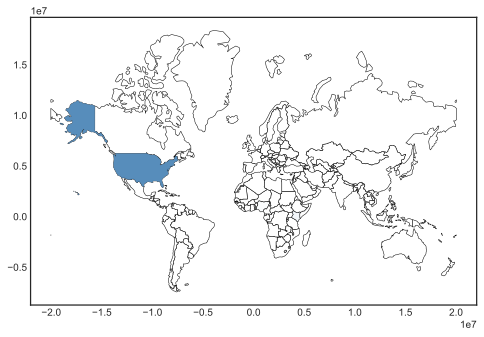

<IPython.core.display.Javascript object>

In [20]:
from mapping import plot_loadings

plot_loadings(loadings)